# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [3]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

/home/yangshiyu89/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:280: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


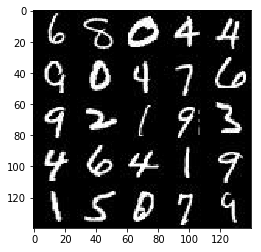

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

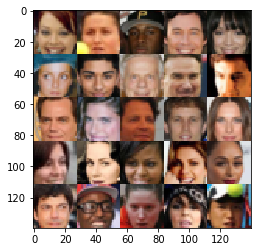

In [5]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [6]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1


/home/yangshiyu89/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [7]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input_images = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels))
    z_data = tf.placeholder(tf.float32, (None, z_dim))
    learning_rate = tf.placeholder(tf.float32)
    return real_input_images, z_data, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [21]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)

        flat = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits)
        
    return output, logits

    
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [22]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z, 7*7*256)
        
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
     
        x2 = tf.layers.conv2d_transpose(x1, 128, 1, strides=1, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
       
        x3 = tf.layers.conv2d_transpose(x2, 64, 3, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 3, strides=2, padding='same')
       
        
        output = tf.tanh(logits) 

    
    
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [10]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    alpha = 0.2
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [23]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    gen_updates = [opt for opt in update_ops if opt.name.startswith('generator')]
    with tf.control_dependencies(gen_updates):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [24]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [32]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    samples, losses = [], []
    steps = 0
    
    image_width = data_shape[1]
    image_height = data_shape[2]
    if data_image_mode == "L":
        image_channels = 1
    else:
        image_channels = 3
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss,g_loss = model_loss(input_real, input_z, image_channels)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z})
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images, lr:learning_rate})
                    train_loss_g = g_loss.eval({input_z: batch_z, lr:learning_rate})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 9, input_z, data_shape[3], data_image_mode)
                    saver.save(sess, './checkpoints/generator.ckpt')
                    
    return losses, samples
                
                
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 10.5551... Generator Loss: 0.0007
Epoch 1/2... Discriminator Loss: 3.6359... Generator Loss: 9.7828
Epoch 1/2... Discriminator Loss: 0.4757... Generator Loss: 2.6143
Epoch 1/2... Discriminator Loss: 2.5071... Generator Loss: 0.1632
Epoch 1/2... Discriminator Loss: 2.9566... Generator Loss: 0.0879
Epoch 1/2... Discriminator Loss: 1.4946... Generator Loss: 2.2158
Epoch 1/2... Discriminator Loss: 1.1465... Generator Loss: 0.9458
Epoch 1/2... Discriminator Loss: 1.8501... Generator Loss: 0.2368
Epoch 1/2... Discriminator Loss: 3.8692... Generator Loss: 0.0298
Epoch 1/2... Discriminator Loss: 0.9140... Generator Loss: 1.0192


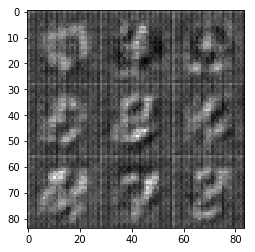

Epoch 1/2... Discriminator Loss: 0.8872... Generator Loss: 1.1877
Epoch 1/2... Discriminator Loss: 1.5494... Generator Loss: 3.2735
Epoch 1/2... Discriminator Loss: 2.7280... Generator Loss: 0.0798
Epoch 1/2... Discriminator Loss: 0.4072... Generator Loss: 1.6011
Epoch 1/2... Discriminator Loss: 0.8390... Generator Loss: 0.9767
Epoch 1/2... Discriminator Loss: 0.7241... Generator Loss: 0.9595
Epoch 1/2... Discriminator Loss: 0.7448... Generator Loss: 0.9801
Epoch 1/2... Discriminator Loss: 1.5741... Generator Loss: 4.2747
Epoch 1/2... Discriminator Loss: 0.8386... Generator Loss: 1.2644
Epoch 1/2... Discriminator Loss: 1.0815... Generator Loss: 1.0716


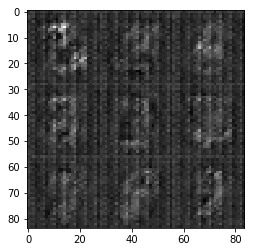

Epoch 1/2... Discriminator Loss: 0.8391... Generator Loss: 1.1655
Epoch 1/2... Discriminator Loss: 0.6834... Generator Loss: 0.9772
Epoch 1/2... Discriminator Loss: 0.7296... Generator Loss: 1.3510
Epoch 1/2... Discriminator Loss: 0.5131... Generator Loss: 1.7962
Epoch 1/2... Discriminator Loss: 0.9364... Generator Loss: 1.4366
Epoch 1/2... Discriminator Loss: 0.5630... Generator Loss: 1.2116
Epoch 1/2... Discriminator Loss: 0.4773... Generator Loss: 1.4457
Epoch 1/2... Discriminator Loss: 0.6040... Generator Loss: 0.9791
Epoch 1/2... Discriminator Loss: 1.0790... Generator Loss: 1.4259
Epoch 1/2... Discriminator Loss: 0.9587... Generator Loss: 1.1216


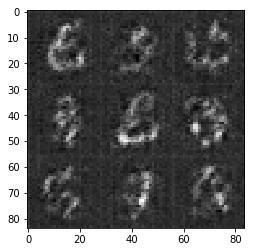

Epoch 1/2... Discriminator Loss: 1.1718... Generator Loss: 2.0134
Epoch 1/2... Discriminator Loss: 1.0796... Generator Loss: 0.5747
Epoch 1/2... Discriminator Loss: 0.6522... Generator Loss: 1.2507
Epoch 1/2... Discriminator Loss: 0.5442... Generator Loss: 1.3631
Epoch 1/2... Discriminator Loss: 0.6320... Generator Loss: 0.9975
Epoch 1/2... Discriminator Loss: 0.6004... Generator Loss: 1.0225
Epoch 1/2... Discriminator Loss: 0.2838... Generator Loss: 1.9545
Epoch 1/2... Discriminator Loss: 0.6683... Generator Loss: 0.9273
Epoch 1/2... Discriminator Loss: 0.4700... Generator Loss: 2.3131
Epoch 1/2... Discriminator Loss: 0.6020... Generator Loss: 0.9909


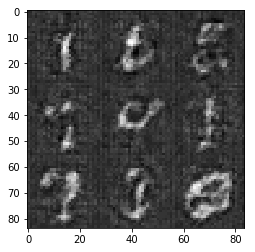

Epoch 1/2... Discriminator Loss: 0.3068... Generator Loss: 1.6911
Epoch 1/2... Discriminator Loss: 0.3648... Generator Loss: 1.6754
Epoch 1/2... Discriminator Loss: 0.2604... Generator Loss: 1.8648
Epoch 1/2... Discriminator Loss: 0.2118... Generator Loss: 1.9597
Epoch 1/2... Discriminator Loss: 0.1159... Generator Loss: 2.7987
Epoch 1/2... Discriminator Loss: 0.0606... Generator Loss: 3.5605
Epoch 2/2... Discriminator Loss: 0.0256... Generator Loss: 4.9820
Epoch 2/2... Discriminator Loss: 0.2270... Generator Loss: 1.8223
Epoch 2/2... Discriminator Loss: 0.0703... Generator Loss: 3.3214
Epoch 2/2... Discriminator Loss: 4.4021... Generator Loss: 5.9387


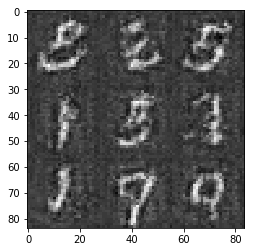

Epoch 2/2... Discriminator Loss: 0.9171... Generator Loss: 1.0355
Epoch 2/2... Discriminator Loss: 0.9495... Generator Loss: 0.9591
Epoch 2/2... Discriminator Loss: 1.2479... Generator Loss: 0.4355
Epoch 2/2... Discriminator Loss: 0.7859... Generator Loss: 1.7086
Epoch 2/2... Discriminator Loss: 0.7043... Generator Loss: 1.8984
Epoch 2/2... Discriminator Loss: 0.5959... Generator Loss: 1.2499
Epoch 2/2... Discriminator Loss: 0.5910... Generator Loss: 1.8596
Epoch 2/2... Discriminator Loss: 0.5910... Generator Loss: 2.3904
Epoch 2/2... Discriminator Loss: 0.8179... Generator Loss: 1.0789
Epoch 2/2... Discriminator Loss: 0.8035... Generator Loss: 0.9800


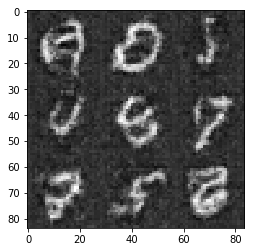

Epoch 2/2... Discriminator Loss: 1.1273... Generator Loss: 3.3973
Epoch 2/2... Discriminator Loss: 0.8288... Generator Loss: 0.7593
Epoch 2/2... Discriminator Loss: 0.3501... Generator Loss: 1.5429
Epoch 2/2... Discriminator Loss: 0.0780... Generator Loss: 4.1357
Epoch 2/2... Discriminator Loss: 0.1564... Generator Loss: 2.4525
Epoch 2/2... Discriminator Loss: 0.0598... Generator Loss: 3.8845
Epoch 2/2... Discriminator Loss: 0.2185... Generator Loss: 2.0389
Epoch 2/2... Discriminator Loss: 0.1008... Generator Loss: 2.8998
Epoch 2/2... Discriminator Loss: 0.0425... Generator Loss: 4.0282
Epoch 2/2... Discriminator Loss: 0.1142... Generator Loss: 2.7564


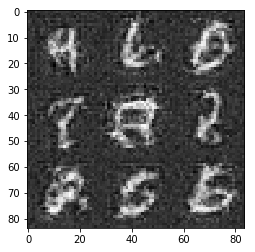

Epoch 2/2... Discriminator Loss: 0.0516... Generator Loss: 3.7011
Epoch 2/2... Discriminator Loss: 0.0845... Generator Loss: 2.9856
Epoch 2/2... Discriminator Loss: 0.0378... Generator Loss: 4.2196
Epoch 2/2... Discriminator Loss: 0.0524... Generator Loss: 3.6508
Epoch 2/2... Discriminator Loss: 2.0141... Generator Loss: 3.1128
Epoch 2/2... Discriminator Loss: 1.0079... Generator Loss: 1.7834
Epoch 2/2... Discriminator Loss: 1.1621... Generator Loss: 0.9401
Epoch 2/2... Discriminator Loss: 1.1276... Generator Loss: 0.8917
Epoch 2/2... Discriminator Loss: 0.8480... Generator Loss: 1.0686
Epoch 2/2... Discriminator Loss: 0.9581... Generator Loss: 0.7639


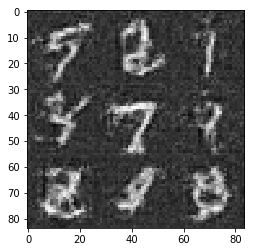

Epoch 2/2... Discriminator Loss: 0.9287... Generator Loss: 1.6081
Epoch 2/2... Discriminator Loss: 0.8328... Generator Loss: 1.1224
Epoch 2/2... Discriminator Loss: 1.1891... Generator Loss: 2.9863
Epoch 2/2... Discriminator Loss: 0.6281... Generator Loss: 1.4676
Epoch 2/2... Discriminator Loss: 1.8530... Generator Loss: 0.2403
Epoch 2/2... Discriminator Loss: 0.6491... Generator Loss: 1.7552
Epoch 2/2... Discriminator Loss: 0.7995... Generator Loss: 1.1780
Epoch 2/2... Discriminator Loss: 0.5863... Generator Loss: 1.3898
Epoch 2/2... Discriminator Loss: 0.5738... Generator Loss: 2.0363
Epoch 2/2... Discriminator Loss: 0.9812... Generator Loss: 0.6647


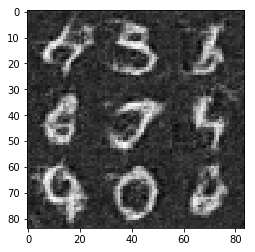

Epoch 2/2... Discriminator Loss: 0.5289... Generator Loss: 2.2248
Epoch 2/2... Discriminator Loss: 1.1513... Generator Loss: 0.5749
Epoch 2/2... Discriminator Loss: 0.6609... Generator Loss: 2.3657


In [33]:
batch_size = 128
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.8810... Generator Loss: 16.7802
Epoch 1/1... Discriminator Loss: 2.6137... Generator Loss: 0.2069
Epoch 1/1... Discriminator Loss: 1.3091... Generator Loss: 0.5917
Epoch 1/1... Discriminator Loss: 1.1874... Generator Loss: 3.0302
Epoch 1/1... Discriminator Loss: 0.2441... Generator Loss: 2.8917
Epoch 1/1... Discriminator Loss: 0.3612... Generator Loss: 1.4486
Epoch 1/1... Discriminator Loss: 0.2642... Generator Loss: 1.9018
Epoch 1/1... Discriminator Loss: 0.3315... Generator Loss: 2.4582
Epoch 1/1... Discriminator Loss: 0.6270... Generator Loss: 1.1392
Epoch 1/1... Discriminator Loss: 0.8949... Generator Loss: 0.7135


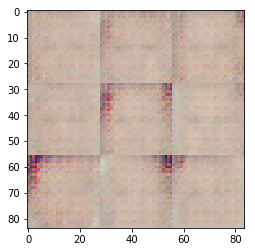

Epoch 1/1... Discriminator Loss: 0.6559... Generator Loss: 1.2257
Epoch 1/1... Discriminator Loss: 0.8590... Generator Loss: 1.4436
Epoch 1/1... Discriminator Loss: 0.6606... Generator Loss: 0.9824
Epoch 1/1... Discriminator Loss: 3.6213... Generator Loss: 0.0661
Epoch 1/1... Discriminator Loss: 1.3531... Generator Loss: 0.6481
Epoch 1/1... Discriminator Loss: 1.2650... Generator Loss: 0.7774
Epoch 1/1... Discriminator Loss: 1.3379... Generator Loss: 0.7912
Epoch 1/1... Discriminator Loss: 1.3379... Generator Loss: 0.7546
Epoch 1/1... Discriminator Loss: 1.3530... Generator Loss: 0.6842
Epoch 1/1... Discriminator Loss: 1.2410... Generator Loss: 0.7092


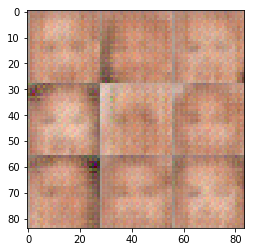

Epoch 1/1... Discriminator Loss: 1.1831... Generator Loss: 1.0107
Epoch 1/1... Discriminator Loss: 1.1569... Generator Loss: 0.9188
Epoch 1/1... Discriminator Loss: 1.4067... Generator Loss: 1.0499
Epoch 1/1... Discriminator Loss: 1.3572... Generator Loss: 0.9545
Epoch 1/1... Discriminator Loss: 1.2935... Generator Loss: 0.8319
Epoch 1/1... Discriminator Loss: 1.1852... Generator Loss: 0.7835
Epoch 1/1... Discriminator Loss: 1.4194... Generator Loss: 1.0550
Epoch 1/1... Discriminator Loss: 1.2550... Generator Loss: 1.1272
Epoch 1/1... Discriminator Loss: 1.2575... Generator Loss: 0.7173
Epoch 1/1... Discriminator Loss: 1.3318... Generator Loss: 0.6598


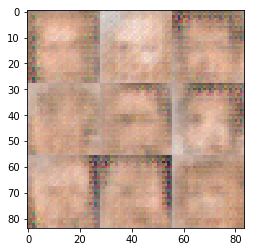

Epoch 1/1... Discriminator Loss: 1.3583... Generator Loss: 1.1520
Epoch 1/1... Discriminator Loss: 1.4324... Generator Loss: 0.5205
Epoch 1/1... Discriminator Loss: 1.2591... Generator Loss: 0.8285
Epoch 1/1... Discriminator Loss: 1.2985... Generator Loss: 0.6502
Epoch 1/1... Discriminator Loss: 1.2831... Generator Loss: 0.6675
Epoch 1/1... Discriminator Loss: 1.3409... Generator Loss: 0.6953
Epoch 1/1... Discriminator Loss: 1.3022... Generator Loss: 0.9227
Epoch 1/1... Discriminator Loss: 1.2947... Generator Loss: 0.6310
Epoch 1/1... Discriminator Loss: 1.2934... Generator Loss: 0.6777
Epoch 1/1... Discriminator Loss: 1.6248... Generator Loss: 0.4067


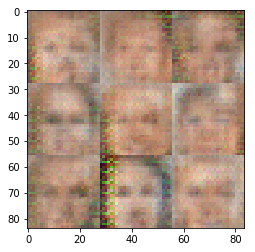

Epoch 1/1... Discriminator Loss: 1.4574... Generator Loss: 0.4509
Epoch 1/1... Discriminator Loss: 1.4118... Generator Loss: 0.9141
Epoch 1/1... Discriminator Loss: 1.2870... Generator Loss: 0.7959
Epoch 1/1... Discriminator Loss: 1.2486... Generator Loss: 0.6605
Epoch 1/1... Discriminator Loss: 1.4621... Generator Loss: 0.4043
Epoch 1/1... Discriminator Loss: 1.3079... Generator Loss: 0.8420
Epoch 1/1... Discriminator Loss: 1.3700... Generator Loss: 1.2226
Epoch 1/1... Discriminator Loss: 1.5049... Generator Loss: 0.3541
Epoch 1/1... Discriminator Loss: 1.6441... Generator Loss: 0.2929
Epoch 1/1... Discriminator Loss: 1.3809... Generator Loss: 0.8629


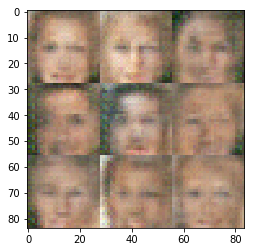

Epoch 1/1... Discriminator Loss: 1.3158... Generator Loss: 0.6525
Epoch 1/1... Discriminator Loss: 1.2489... Generator Loss: 0.7863
Epoch 1/1... Discriminator Loss: 1.6620... Generator Loss: 0.5700
Epoch 1/1... Discriminator Loss: 1.3581... Generator Loss: 0.6563
Epoch 1/1... Discriminator Loss: 1.2483... Generator Loss: 0.7661
Epoch 1/1... Discriminator Loss: 1.5274... Generator Loss: 0.6978
Epoch 1/1... Discriminator Loss: 1.3910... Generator Loss: 1.1149
Epoch 1/1... Discriminator Loss: 1.2424... Generator Loss: 0.7483
Epoch 1/1... Discriminator Loss: 1.3648... Generator Loss: 0.9568
Epoch 1/1... Discriminator Loss: 1.4074... Generator Loss: 0.8954


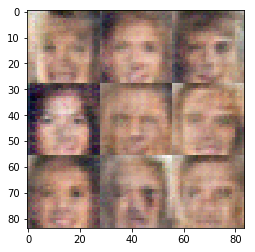

Epoch 1/1... Discriminator Loss: 1.2753... Generator Loss: 0.8254
Epoch 1/1... Discriminator Loss: 1.3815... Generator Loss: 0.6698
Epoch 1/1... Discriminator Loss: 1.4190... Generator Loss: 0.4424
Epoch 1/1... Discriminator Loss: 1.4720... Generator Loss: 0.4388
Epoch 1/1... Discriminator Loss: 1.3908... Generator Loss: 0.5046
Epoch 1/1... Discriminator Loss: 1.2796... Generator Loss: 0.6967
Epoch 1/1... Discriminator Loss: 1.8333... Generator Loss: 1.7783
Epoch 1/1... Discriminator Loss: 1.3963... Generator Loss: 1.6084
Epoch 1/1... Discriminator Loss: 1.3292... Generator Loss: 0.6848
Epoch 1/1... Discriminator Loss: 1.9461... Generator Loss: 0.2258


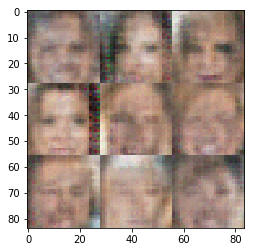

Epoch 1/1... Discriminator Loss: 1.3689... Generator Loss: 0.6467
Epoch 1/1... Discriminator Loss: 1.3252... Generator Loss: 0.8579
Epoch 1/1... Discriminator Loss: 2.3353... Generator Loss: 2.1436
Epoch 1/1... Discriminator Loss: 2.0031... Generator Loss: 0.5265
Epoch 1/1... Discriminator Loss: 1.4233... Generator Loss: 0.7132
Epoch 1/1... Discriminator Loss: 1.3247... Generator Loss: 0.6895
Epoch 1/1... Discriminator Loss: 1.3768... Generator Loss: 0.8550
Epoch 1/1... Discriminator Loss: 1.4354... Generator Loss: 0.6060
Epoch 1/1... Discriminator Loss: 1.2596... Generator Loss: 0.7282
Epoch 1/1... Discriminator Loss: 1.2508... Generator Loss: 0.6279


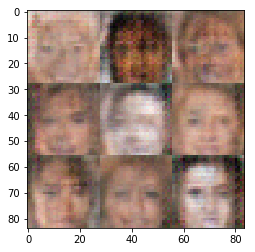

Epoch 1/1... Discriminator Loss: 1.3341... Generator Loss: 0.7020
Epoch 1/1... Discriminator Loss: 1.4075... Generator Loss: 0.7282
Epoch 1/1... Discriminator Loss: 1.3151... Generator Loss: 0.8440
Epoch 1/1... Discriminator Loss: 1.3696... Generator Loss: 0.6565
Epoch 1/1... Discriminator Loss: 1.3096... Generator Loss: 0.6941
Epoch 1/1... Discriminator Loss: 1.3714... Generator Loss: 0.6843
Epoch 1/1... Discriminator Loss: 1.3310... Generator Loss: 0.7597
Epoch 1/1... Discriminator Loss: 1.3355... Generator Loss: 0.7175
Epoch 1/1... Discriminator Loss: 1.3007... Generator Loss: 0.7725
Epoch 1/1... Discriminator Loss: 1.4395... Generator Loss: 1.0207


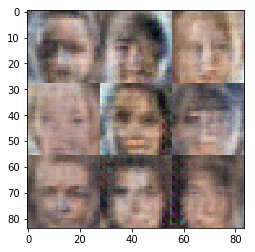

Epoch 1/1... Discriminator Loss: 1.3397... Generator Loss: 0.6000
Epoch 1/1... Discriminator Loss: 1.3873... Generator Loss: 0.6055
Epoch 1/1... Discriminator Loss: 1.3311... Generator Loss: 0.7562
Epoch 1/1... Discriminator Loss: 1.4137... Generator Loss: 0.7046
Epoch 1/1... Discriminator Loss: 1.3276... Generator Loss: 0.8505
Epoch 1/1... Discriminator Loss: 1.3643... Generator Loss: 0.5681
Epoch 1/1... Discriminator Loss: 1.3380... Generator Loss: 0.7133
Epoch 1/1... Discriminator Loss: 1.3336... Generator Loss: 0.8820
Epoch 1/1... Discriminator Loss: 2.0547... Generator Loss: 0.2311
Epoch 1/1... Discriminator Loss: 1.3380... Generator Loss: 0.7997


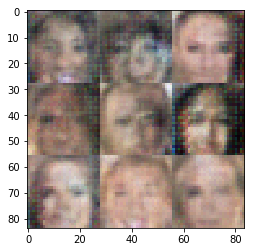

Epoch 1/1... Discriminator Loss: 1.2147... Generator Loss: 0.7228
Epoch 1/1... Discriminator Loss: 1.3913... Generator Loss: 0.7395
Epoch 1/1... Discriminator Loss: 1.1977... Generator Loss: 0.9027
Epoch 1/1... Discriminator Loss: 1.3226... Generator Loss: 0.8009
Epoch 1/1... Discriminator Loss: 1.2493... Generator Loss: 0.8949
Epoch 1/1... Discriminator Loss: 1.2588... Generator Loss: 0.8956
Epoch 1/1... Discriminator Loss: 1.2536... Generator Loss: 1.0947
Epoch 1/1... Discriminator Loss: 1.1970... Generator Loss: 0.9279
Epoch 1/1... Discriminator Loss: 1.1566... Generator Loss: 0.6614
Epoch 1/1... Discriminator Loss: 1.4166... Generator Loss: 0.9621


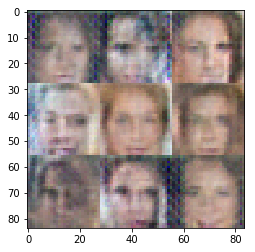

Epoch 1/1... Discriminator Loss: 1.2568... Generator Loss: 0.8442
Epoch 1/1... Discriminator Loss: 1.3252... Generator Loss: 0.7599
Epoch 1/1... Discriminator Loss: 1.2938... Generator Loss: 0.6938
Epoch 1/1... Discriminator Loss: 1.3928... Generator Loss: 0.6182
Epoch 1/1... Discriminator Loss: 1.3069... Generator Loss: 0.7680
Epoch 1/1... Discriminator Loss: 1.1702... Generator Loss: 0.7981
Epoch 1/1... Discriminator Loss: 1.6064... Generator Loss: 0.3091
Epoch 1/1... Discriminator Loss: 1.4956... Generator Loss: 0.6221
Epoch 1/1... Discriminator Loss: 1.2988... Generator Loss: 0.7136
Epoch 1/1... Discriminator Loss: 1.4143... Generator Loss: 0.6705


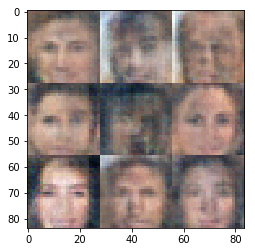

Epoch 1/1... Discriminator Loss: 1.3049... Generator Loss: 0.7057
Epoch 1/1... Discriminator Loss: 1.3675... Generator Loss: 0.7196
Epoch 1/1... Discriminator Loss: 1.3535... Generator Loss: 0.7652
Epoch 1/1... Discriminator Loss: 1.4281... Generator Loss: 0.7788
Epoch 1/1... Discriminator Loss: 1.3416... Generator Loss: 0.7477
Epoch 1/1... Discriminator Loss: 1.3856... Generator Loss: 0.7392
Epoch 1/1... Discriminator Loss: 1.3259... Generator Loss: 0.7099
Epoch 1/1... Discriminator Loss: 1.3621... Generator Loss: 0.7529
Epoch 1/1... Discriminator Loss: 1.3308... Generator Loss: 0.7905
Epoch 1/1... Discriminator Loss: 1.4064... Generator Loss: 0.6244


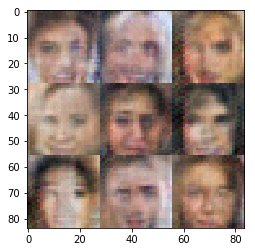

Epoch 1/1... Discriminator Loss: 1.2921... Generator Loss: 0.8153
Epoch 1/1... Discriminator Loss: 1.3427... Generator Loss: 0.8495
Epoch 1/1... Discriminator Loss: 1.3588... Generator Loss: 0.6043
Epoch 1/1... Discriminator Loss: 1.2994... Generator Loss: 0.7343
Epoch 1/1... Discriminator Loss: 1.3667... Generator Loss: 0.8714
Epoch 1/1... Discriminator Loss: 1.3594... Generator Loss: 0.9852
Epoch 1/1... Discriminator Loss: 1.8176... Generator Loss: 1.7041
Epoch 1/1... Discriminator Loss: 1.0024... Generator Loss: 0.7613
Epoch 1/1... Discriminator Loss: 1.3589... Generator Loss: 0.5804
Epoch 1/1... Discriminator Loss: 1.3192... Generator Loss: 0.5890


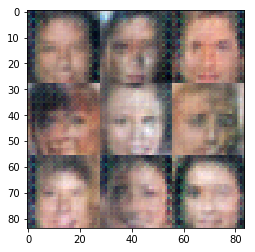

Epoch 1/1... Discriminator Loss: 1.3842... Generator Loss: 0.4742
Epoch 1/1... Discriminator Loss: 1.3213... Generator Loss: 0.7864
Epoch 1/1... Discriminator Loss: 1.4195... Generator Loss: 0.6248
Epoch 1/1... Discriminator Loss: 1.2155... Generator Loss: 0.6669
Epoch 1/1... Discriminator Loss: 1.4327... Generator Loss: 0.7324
Epoch 1/1... Discriminator Loss: 0.7425... Generator Loss: 2.4121
Epoch 1/1... Discriminator Loss: 2.9242... Generator Loss: 3.3113
Epoch 1/1... Discriminator Loss: 1.1786... Generator Loss: 0.9208
Epoch 1/1... Discriminator Loss: 1.2414... Generator Loss: 0.8493
Epoch 1/1... Discriminator Loss: 1.2178... Generator Loss: 0.9153


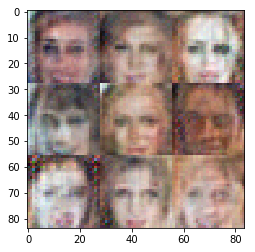

Epoch 1/1... Discriminator Loss: 0.8067... Generator Loss: 2.8896
Epoch 1/1... Discriminator Loss: 1.0270... Generator Loss: 0.9631
Epoch 1/1... Discriminator Loss: 1.1261... Generator Loss: 0.8107
Epoch 1/1... Discriminator Loss: 0.7245... Generator Loss: 1.1675
Epoch 1/1... Discriminator Loss: 0.5513... Generator Loss: 1.0137
Epoch 1/1... Discriminator Loss: 2.5335... Generator Loss: 4.8685
Epoch 1/1... Discriminator Loss: 1.1032... Generator Loss: 0.6751
Epoch 1/1... Discriminator Loss: 1.1535... Generator Loss: 1.1981


In [34]:
batch_size = 128
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.